### Non-temporal Classification with LGBMClassifier

Data preprocessing:
1. Categorical features have been OneHotEncoded
2. Target value vhigh was merged into high
3. Similar columns were mearged together

Model trainig:
1. The default configuration performs mostly better than any other configuration of parameters tried

Results:
1. F1_score on test data: **68.26**
2. Included important features plot
3. Included confusion matrix


In [157]:
import pandas as pd
import numpy as np

In [158]:
df = pd.read_parquet('../../data/8. data_for_modelling/Non Temporal Datasets/train_nontemporal_classification.parquet.gz')
df.shape

(300960, 123)

In [159]:
df.shape

(300960, 123)

In [160]:
from sklearn.preprocessing import LabelEncoder

# "OneHotEncode" categorial fetures
def encodeCategoricalFeatures(main_df):
    df = main_df.copy()

    df['holiday_name'] = LabelEncoder().fit_transform(df['holiday_name'])

    dummies = pd.get_dummies(df["season"], prefix="season")
    df = pd.concat([df, dummies], axis='columns')

    dummies = pd.get_dummies(df["voivodship"], prefix="voivodship")
    df = pd.concat([df, dummies], axis='columns')

    dummies = pd.get_dummies(df["powiat_voivod"])
    df = pd.concat([df, dummies], axis='columns')

    # dummies = pd.get_dummies(df["holiday_name"], prefix="holiday")
    # df = pd.concat([df, dummies], axis='columns')
    
    return df

# merge high and vhigh CAQI values
# replace ['vlow', 'low', 'medium', 'high', 'vhigh'] with [0, 1, 2, 3, 3]
def encodeTargetVariable(main_df):
    df = main_df.copy()
    df['CAQI_level'].replace(to_replace=['vlow', 'low', 'medium', 'high', 'vhigh'], value=[0, 1, 2, 3, 3], inplace=True)
    return df

# group similar cols together (and sum their values)
# https://github.com/OmdenaAI/warsaw-poland-chapter-air-pollution/blob/main/src/tasks/task-4-modeling/Joseph%20Antony_Modelling/1.%20BaseLine%20Model.ipynb
def groupFeatures(main_df):
    df = main_df.copy()

    df['emission of particules'] = df[[col for col in df.columns if col.startswith('emission of particulates ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('emission of particulates')]

    df['emission of pollutant gasees'] = df[[col for col in df.columns if col.startswith('emission of pollutant gases ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('emission of pollutant gases ')]

    df['total vehicles'] = df[[col for col in df.columns if col.startswith('total vehicles ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('total vehicles ')]

    df['vehicles by type and fuel'] = df[[col for col in df.columns if col.startswith('vehicles by type and fuel ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('vehicles by type and fuel ')]

    df['crop production'] = df[[col for col in df.columns if col.startswith('crop production ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('crop production ')]

    df['air pollution reduction systems'] = df[[col for col in df.columns if col.startswith('air pollution reduction systems ')]].sum(axis=1)
    df = df.loc[:, ~df.columns.str.startswith('air pollution reduction systems ')]

    return df

# drop cols
def dropFeatures(main_df):
    df = main_df.copy()
    cols = [
        'production of electricity - water power plants and wind, biomass and wastes power plants, total',
        'production of electricity - water power plants',
        'production of electricity - thermal power plants, total',
        'production of electricity - thermal public power plants',
        'production of electricity - thermal autoproducing power plants',
        'production of electricity - from renewable energy sources',
        'production of electricity - share of renewable energy sources in total production of electricity',
        'production of electricity - relation of electricity production to electricity consumption',
        'forest fires - number of forest fires, total',
        'plants of significant nuisance - possessing systems to reduce the emission of gases',
        'plants of significant nuisance - possessing systems to reduce the emission of particulates',
        'season',
        'voivodship',
        'powiat_voivod'
    ]
    df.drop(columns=cols, inplace=True)
    return df

In [161]:
df = (df.pipe(encodeCategoricalFeatures)
      .pipe(encodeTargetVariable)
      .pipe(groupFeatures)
      .pipe(dropFeatures)
      )

In [162]:
X_df = df.drop('CAQI_level', axis=1)
Y_df = df['CAQI_level']

In [163]:
X = X_df.values
y = Y_df.values

#### Model training

In [164]:
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight

lgbm = LGBMClassifier(num_leaves=150, reg_lambda=0.01)

# we fit the model on the training set
lgbm.fit(X, y)

LGBMClassifier(num_leaves=150, reg_lambda=0.01)

### Feature importance

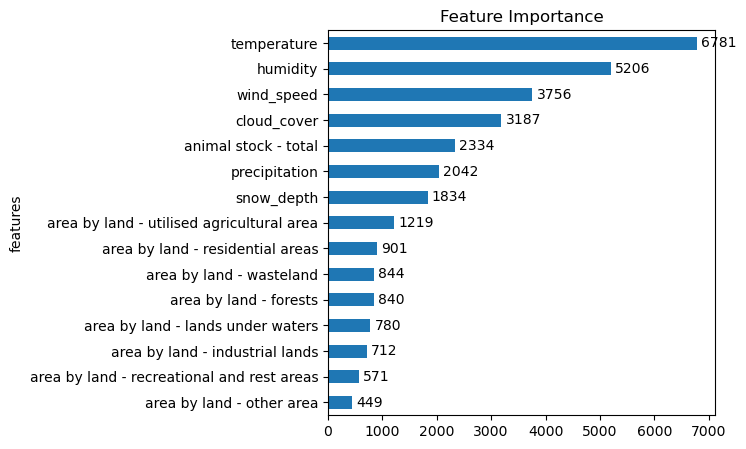

In [165]:
# get feature importances and corresponding feature names
importances = lgbm.feature_importances_
feature_names = X_df.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

#Creating a dataframe for feature importance
feat_imp_df = \
pd.DataFrame({
    'features': feature_names[:15],
    'importance': np.round(importances[:15], 4)
}).set_index('features').sort_values('importance')

ax = feat_imp_df.plot(kind='barh', figsize=(5, 5))
ax.set_title("Feature Importance");
ax.bar_label(ax.containers[0], padding=3);
ax.legend().remove()
ax.figure.savefig('most_important_features.png', facecolor="white", bbox_inches='tight')

In [166]:
del(df)

#### Model evaluation

In [167]:
df_test = pd.read_parquet('../../data/8. data_for_modelling/Non Temporal Datasets/test_nontemporal_classification.parquet.gz')

In [168]:
df_test = (df_test.pipe(encodeCategoricalFeatures)
      .pipe(encodeTargetVariable)
      .pipe(groupFeatures)
      .pipe(dropFeatures)
      )

In [169]:
X_test_df = df_test.drop('CAQI_level', axis=1)
Y_test_df = df_test['CAQI_level']

In [170]:
X_test = X_test_df.values
y_test = Y_test_df.values

In [171]:
y_pred = lgbm.predict(X_test)

In [172]:
# Evaluating the model performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76     31913
           1       0.63      0.62      0.63     24346
           2       0.42      0.25      0.31      3683
           3       0.30      0.19      0.23       448

    accuracy                           0.68     60390
   macro avg       0.52      0.46      0.48     60390
weighted avg       0.67      0.68      0.68     60390



In [173]:
lgbm.score(X_test, y_test)

0.6826792515317105

### Confusion matrix

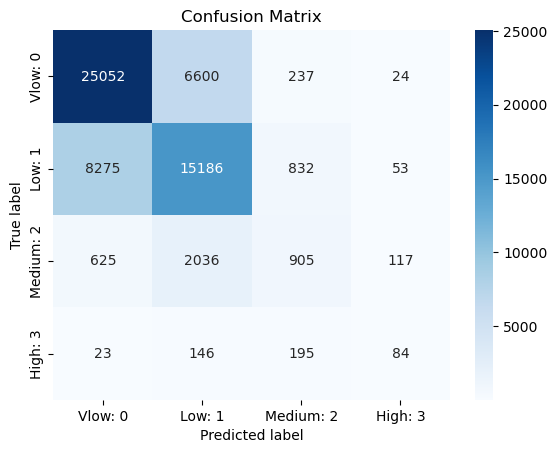

In [174]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Class labels
class_names = ['Vlow: 0', 'Low: 1', 'Medium: 2', 'High: 3']

# Heatmap plot of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Plot labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()